In [ ]:
!pip install tensorflow==2.8
!pip install keras==2.8

### Load

In [1]:
import os
import numpy as np
from music21 import converter, pitch, interval, instrument, note, stream
from matplotlib import pyplot as plt

from xen.visualise import plotPart, plotSparseNoteSequence
from xen.data.songdata import SongDataSet

data_dir = "../../../ml_training/music/mutopia_guitar/"

dataset = SongDataSet()
dataset.loadMidiDir(data_dir)

print(f'Loaded {len(dataset.songs)} Songs') 


Loading 385 files
Loaded 385 Songs


### Filter

In [2]:
dataset.filterTimeSig('4/4')
print(f'{len(dataset.songs)} Songs') 

95 Songs


###  Encode

In [3]:
from xen.data.codecs import SparseNoteSequenceCodec, FlatNoteSequenceCodec

ticksPerQuarter = 4   # 4 = 16th notes, to allow triplets would need to be 12 = 48 per measure
measuresPerSequence = 1

codec = FlatNoteSequenceCodec(ticksPerQuarter, measuresPerSequence, '4/4')
codec.initEncode(dataset)

print(dataset.sequences.shape)

Ignored 20 sequences from ../../../ml_training/music/mutopia_guitar/Matiegka3.mid
Ignored 2 sequences from ../../../ml_training/music/mutopia_guitar/capricho-arabe.mid
Ignored 24 sequences from ../../../ml_training/music/mutopia_guitar/carcassi-op60-03.mid
Ignored 3 sequences from ../../../ml_training/music/mutopia_guitar/horetzky29.mid
Ignored 84 sequences from ../../../ml_training/music/mutopia_guitar/sorf-op6n11.mid
Ignored 42 sequences from ../../../ml_training/music/mutopia_guitar/sorf-op6n07.mid
Ignored 69 sequences from ../../../ml_training/music/mutopia_guitar/claro-de-luna.mid
Ignored 70 sequences from ../../../ml_training/music/mutopia_guitar/moonlight-guitar-duo.mid
Ignored 1 sequences from ../../../ml_training/music/mutopia_guitar/bwv-1006a_3g.mid
Ignored 1 sequences from ../../../ml_training/music/mutopia_guitar/guitar-skole-no-09.mid
Ignored 2 sequences from ../../../ml_training/music/mutopia_guitar/Sor_Etude_Opus35_14.mid
Ignored 1 sequences from ../../../ml_training/mus

In [4]:
import tensorflow as tf
from xen.models.autoencoder import AutoEncoder

autoencoder = AutoEncoder(dataset.sequences.shape[1], 40)
autoencoder.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

2022-10-09 19:20:40.886201: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train

In [5]:


autoencoder.train(dataset.sequences, epochs = 500)


Epoch 1/500
99/99 [==============================] - 1s 3ms/step - loss: 0.1261
Epoch 2/500
99/99 [==============================] - 0s 3ms/step - loss: 0.0637
Epoch 3/500
99/99 [==============================] - 0s 3ms/step - loss: 0.0575
Epoch 4/500
99/99 [==============================] - 0s 3ms/step - loss: 0.0533
Epoch 5/500
99/99 [==============================] - 0s 3ms/step - loss: 0.0487
Epoch 6/500
99/99 [==============================] - 0s 2ms/step - loss: 0.0442
Epoch 7/500
99/99 [==============================] - 0s 2ms/step - loss: 0.0408
Epoch 8/500
99/99 [==============================] - 0s 3ms/step - loss: 0.0383
Epoch 9/500
99/99 [==============================] - 0s 3ms/step - loss: 0.0363
Epoch 10/500
99/99 [==============================] - 0s 3ms/step - loss: 0.0348
Epoch 11/500
99/99 [==============================] - 0s 3ms/step - loss: 0.0335
Epoch 12/500
99/99 [==============================] - 0s 3ms/step - loss: 0.0321
Epoch 13/500
99/99 [=================

In [6]:


def measureRecall(indata, outdata):
    matches = 0
    for i in range(0, len(indata)):
        insequence = indata[i]
        outsequence = outdata[i]
        match = True
        for j in range(len(insequence)):
            if ((insequence[j] >= 0.5 and outsequence[j] < 0.5) or (insequence[j] < 0.5 and outsequence[j] >= 0.5)):
                match = False
                # print(i)
        if (match):
            matches = matches + 1
    return matches
    

output = autoencoder.predict(dataset.sequences)

matches = measureRecall(dataset.sequences, output)
print(f'{matches/len(dataset.sequences)*100}% recall')



75.11870845204179% recall


(3159, 693)


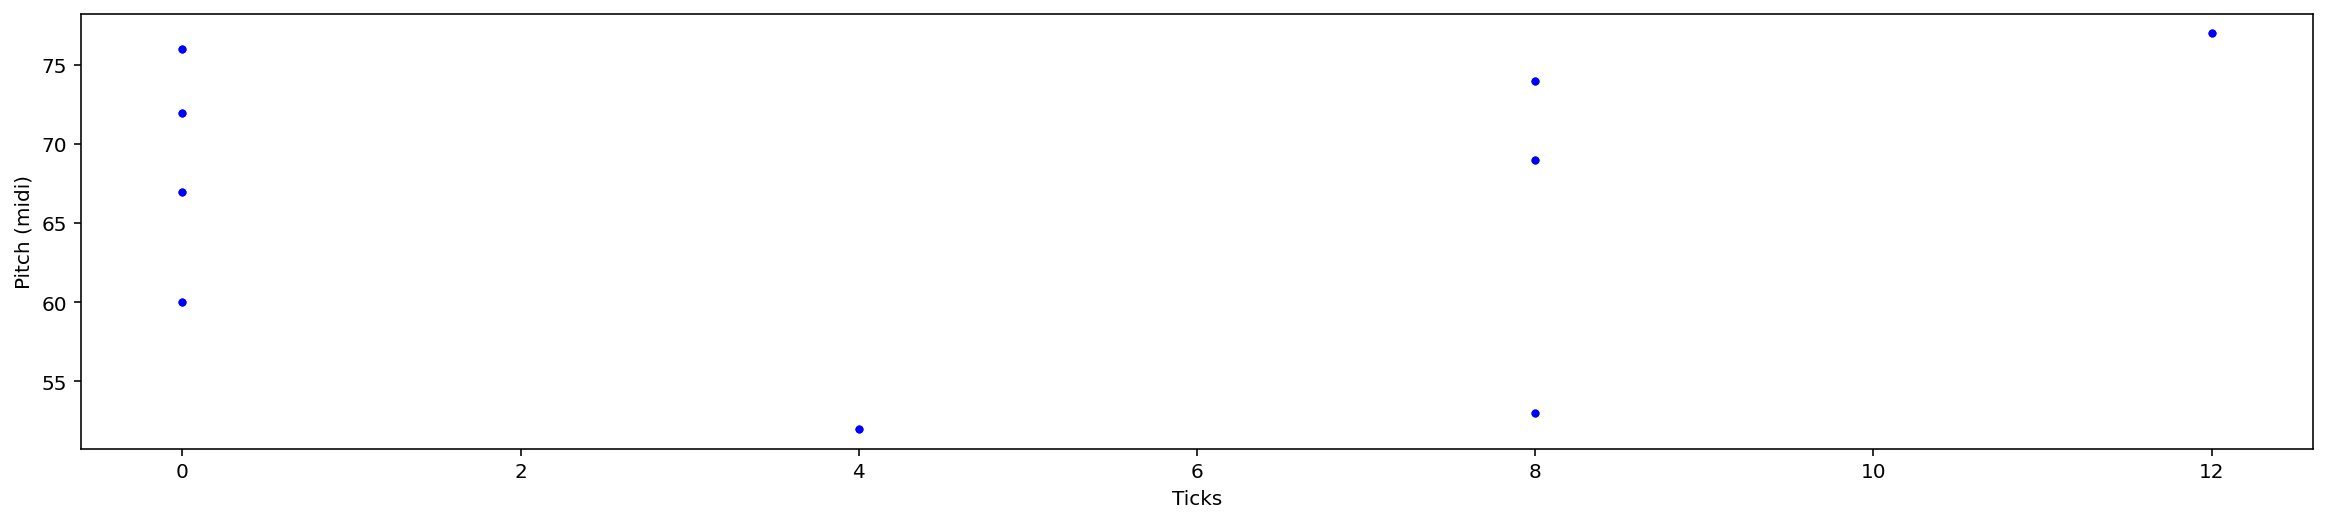

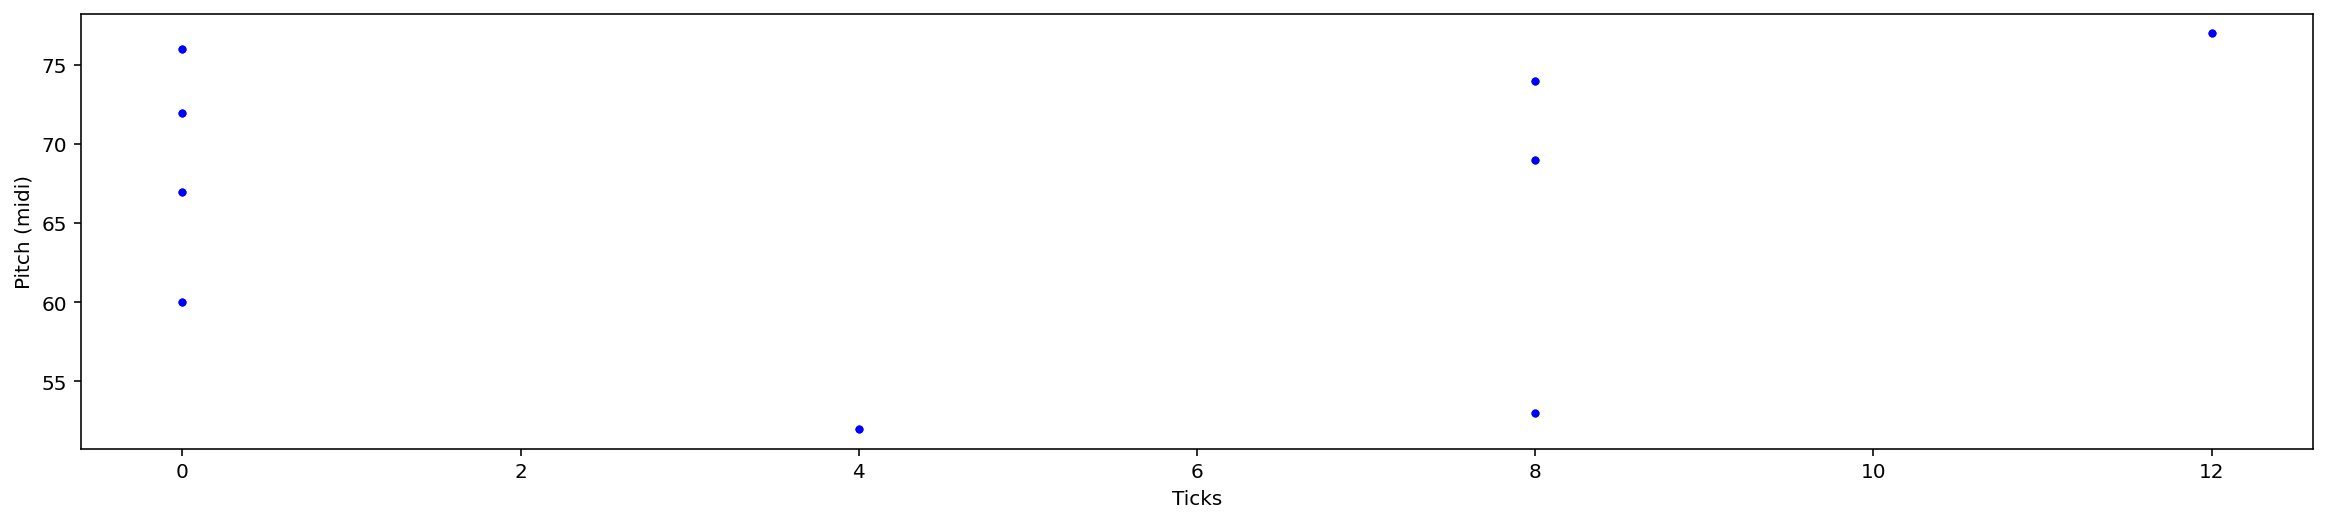

[0.9999999 1.        0.9998823 ... 1.        1.        0.9999998]


In [7]:
index = 13

print(output.shape)


plotSparseNoteSequence(codec.decode(dataset.sequences[index:index+1])[0])
plotSparseNoteSequence(codec.decode(output[index:index+1])[0], threshold = 0.5)


print(np.amax(output, axis = 1))